In [1]:
# Import necessary packages
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import xitorch
from xitorch.optimize import rootfinder
import optuna
from torch.utils.data import TensorDataset, DataLoader
import joblib 
import torch.optim as optim

# Different Potentials with D correction
from FrictionNNModels import PotentialsFricCorrection, Loss, train1Epoch, PP, ReLUSquare, PotsCalXiXiDot, load_model

# Memory management on GPU
import gc

# Import time
import time

# Testify whether GPU is available
print("Cuda is available: ", torch.cuda.is_available())
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print("Device is: ", device)

def memory_stats():
    print("Memory allocated: ", torch.cuda.memory_allocated()/1024**2)
    print("Memory cached: ", torch.cuda.memory_reserved()/1024**2)
memory_stats()

Cuda is available:  False
Device is:  cpu
Memory allocated:  0.0
Memory cached:  0.0


In [2]:
# Load the NN model
# Import the learnt potentials
# modelPrefix = "Trial0112_combined"
# modelPrefix = "Trial0216_smallDRS_smallA_400" # "Trial0216_combined_800"
modelPrefix = "Trial0216_combined_800"
dim_xi = 1
dict_flag = True
NN_flag = 1

myModel = load_model(modelPrefix, torch.device("cpu"), dim_xi, dict_flag, NN_flag)

# Load the Further-trained polynomial model
# Import the learnt potentials
# modelPrefix = "Trial0112_combined"
# modelPrefix = "Trial0216_smallDRS_smallA_400" # "Trial0216_combined_800"
modelPrefix_poly = "Trial0216_combined_800_GivenPoly_grid_LogCross_trained_training_3000_p3"
dim_xi = 1
dict_flag = True
NN_flag = 2

myModel_poly = load_model(modelPrefix_poly, torch.device("cpu"), dim_xi, dict_flag, NN_flag)

In [3]:
# Import data
# dataPrefix = "Trial0216_smallDRS_smallA_400" 
dataPrefix = "Trial0216_combined_800"
shit = torch.load("./data/{0}.pt".format(dataPrefix))
Vs = shit["Vs"]
thetas = shit["thetas"]
fs = shit["fs"]
ts = shit["ts"]

# Now Vs and ts have fixed length
print("Vs.shape: ", Vs.shape)
print("thetas.shape: ", thetas.shape)
print("fs.shape: ", fs.shape)
print("ts.shape: ", ts.shape)

# Calculate Xs
Xs = torch.zeros(Vs.shape)
Xs[:, 1:] = torch.cumulative_trapezoid(Vs, ts)
print("Xs.shape: ", Xs.shape)

# Calculate xis, xiDots trajectories
myPotCal = PotsCalXiXiDot(myModel)
myPotCal.calf(Xs, Vs, ts)

myPotCal_poly = PotsCalXiXiDot(myModel_poly)
myPotCal_poly.calf(Xs, Vs, ts)

xis = myPotCal.xis
xiDots = myPotCal.xiDots
Dins = myPotCal.Dins

xis_poly = myPotCal_poly.xis
xiDots_poly = myPotCal_poly.xiDots
Dins_poly = myPotCal_poly.Dins

print("xis.shape: ", xis.shape)
print("xiDots.shape: ", xiDots.shape)
print("Dins.shape: ", Dins.shape)

Vs.shape:  torch.Size([800, 100])
thetas.shape:  torch.Size([800, 100])
fs.shape:  torch.Size([800, 100])
ts.shape:  torch.Size([800, 100])
Xs.shape:  torch.Size([800, 100])
xis.shape:  torch.Size([800, 100])
xiDots.shape:  torch.Size([800, 100])
Dins.shape:  torch.Size([800, 100])


# Visualize plots of D_dagger, D and W

In [4]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [5]:
# Examine the ranges of different
Xs = Xs.reshape(-1).detach().numpy()
Vs = Vs.reshape(-1).detach().numpy()
xis = xis.reshape(-1).detach().numpy()
xiDots = xiDots.reshape(-1).detach().numpy()
Dins = Dins.reshape(-1).detach().numpy()

xis_poly = xis_poly.reshape(-1).detach().numpy()
xiDots_poly = xiDots_poly.reshape(-1).detach().numpy()
Dins_poly = Dins_poly.reshape(-1).detach().numpy()

print("min(Xs), max(Xs): ", min(Xs), max(Xs))
print("min(Vs), max(Vs): ", min(Vs), max(Vs))
print("min(xis), max(xis): ", min(xis), max(xis))
print("min(xiDots), max(xiDots): ", min(xiDots), max(xiDots))
print("min(Dins), max(Dins): ", min(Dins), max(Dins))
print("min(xis_poly), max(xis_poly): ", min(xis_poly), max(xis_poly))
print("min(xiDots_poly), max(xiDots_poly): ", min(xiDots_poly), max(xiDots_poly))
print("min(Dins_poly), max(Dins_poly): ", min(Dins_poly), max(Dins_poly))

min(Xs), max(Xs):  0.0 12.005895
min(Vs), max(Vs):  0.01 10.0
min(xis), max(xis):  -0.8405108 0.21648905
min(xiDots), max(xiDots):  -16.424503 23.683899
min(Dins), max(Dins):  -1.4361436 4.1601496
min(xis_poly), max(xis_poly):  -0.5649673 0.32619855
min(xiDots_poly), max(xiDots_poly):  -20.838316 34.323124
min(Dins_poly), max(Dins_poly):  -1.2126112 3.5205152


In [6]:
## The ranges of Vs, xs, and xi^dot
# Plot the following functions:
# W(x)
# D_dagger(\dot{x}, \xi)
# D^*(\dot{d})
# D(\dot{\xi}) = (D^*)^*
x = np.linspace(0.0, 12., 100)
dotX = 10. ** np.linspace(-2., 1., 100)
xi = np.linspace(-0.9, 0.3, 100) # np.linspace(-0.7, 0.3, 100)
xiDot = np.linspace(-17, 24, 100) # np.linspace(-15, 9, 100)
Din = np.linspace(-1.5, 4.2) # np.linspace(-1.5, 5., 100)

# Grab all training datasets

In [7]:
# Get different datasets, plot their contributions separately
dataPrefixs = ["Trial0216_smallDRS_smallA_400", "Trial0216_smallDRS_Burigede_400"]
legends = ["Jump", "Continuous"]
colors = ["red", "green"]

# Store all inputs
Xss = []
Vss = []
fss = []
tss = []
xiss = []
xiDotss = []
Dinss = []

xiss_poly = []
xiDotss_poly = []
Dinss_poly = []

# Load different datasets
for dataPrefix in dataPrefixs:
    shit = torch.load("./data/{0}.pt".format(dataPrefix))
    Vs = shit["Vs"]
    thetas = shit["thetas"]
    fs = shit["fs"]
    ts = shit["ts"]

    # Calculate Xs
    Xs = torch.zeros(Vs.shape)
    Xs[:, 1:] = torch.cumulative_trapezoid(Vs, ts)

    # Calculate xis, xiDots trajectories
    myPotCal = PotsCalXiXiDot(myModel)
    myPotCal.calf(Xs, Vs, ts)
    xis = myPotCal.xis
    xiDots = myPotCal.xiDots
    Dins = myPotCal.Dins

    myPotCal_poly = PotsCalXiXiDot(myModel_poly)
    myPotCal_poly.calf(Xs, Vs, ts)
    xis_poly = myPotCal_poly.xis
    xiDots_poly = myPotCal_poly.xiDots
    Dins_poly = myPotCal_poly.Dins

    Xs = Xs.reshape(-1).detach().numpy()
    Vs = Vs.reshape(-1).detach().numpy()
    xis = xis.reshape(-1).detach().numpy()
    xiDots = xiDots.reshape(-1).detach().numpy()
    ts = ts.reshape(-1).detach().numpy()
    fs = fs.reshape(-1).detach().numpy()
    Dins = Dins.reshape(-1).detach().numpy()
    
    xis_poly = xis_poly.reshape(-1).detach().numpy()
    xiDots_poly = xiDots_poly.reshape(-1).detach().numpy()
    Dins_poly = Dins_poly.reshape(-1).detach().numpy()
    
    Xss.append(Xs)
    Vss.append(Vs)
    fss.append(fs)
    tss.append(ts)
    xiss.append(xis)
    xiDotss.append(xiDots)
    Dinss.append(Dins)

    xiss_poly.append(xis_poly)
    xiDotss_poly.append(xiDots_poly)
    Dinss_poly.append(Dins_poly)

# Plot $D^\dagger(V, \xi)$

In [8]:
# Set some plotting standards
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Font size
fsize = 15

Range of D_dagger:  -0.3831742 ,  3.804568


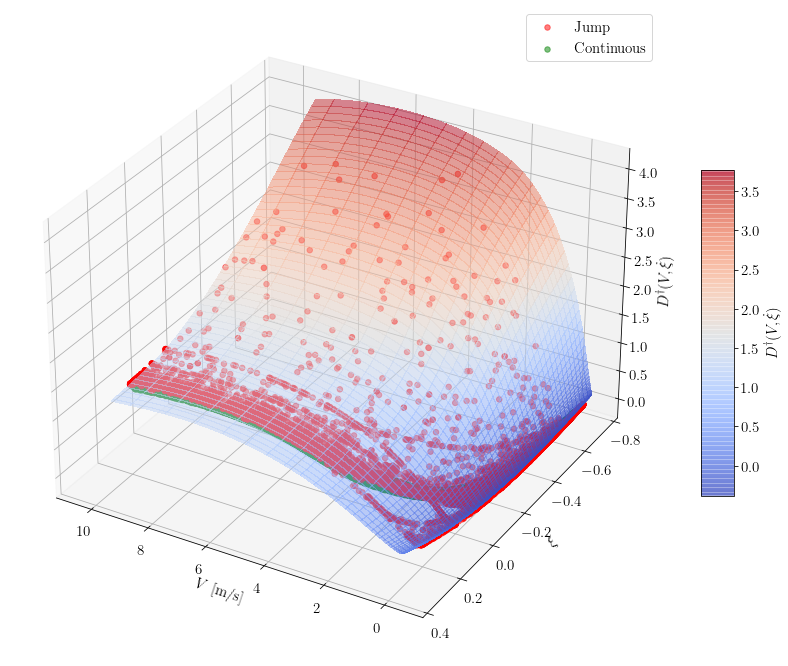

In [9]:
# Compute values for the 2D map
DotX, Xi = np.meshgrid(dotX, xi)
logVFlag = False

# Initialize the plot
fig, ax = plt.subplots(figsize = (15, 12), subplot_kw={"projection": "3d"})
ax.view_init(elev=30, azim=120)
D_dagger_outss = []

for idx in range(len(legends)):
    # Scatter the supporting points
    D_dagger_dataPts = torch.stack([torch.from_numpy(Vss[idx]).float(), torch.from_numpy(xiss[idx]).float()], dim=1)
    D_dagger_dataPts_val = torch.squeeze(myPotCal.D_dagger(D_dagger_dataPts))
    D_dagger_dataPts_val = D_dagger_dataPts_val.detach().numpy()
    D_dagger_outss.append(D_dagger_dataPts_val)
    
    # Scatter the data points first
    if logVFlag:
        Vin = np.log10(D_dagger_dataPts[:, 0])
    else:
        Vin = D_dagger_dataPts[:, 0]

    ax.scatter(Vin, 
            D_dagger_dataPts[:, 1], 
            D_dagger_dataPts_val, 
            s=30, 
            marker="o", 
            alpha=0.5, 
            c=colors[idx], 
            label=legends[idx])

ax.legend(fontsize=fsize)

# Plot the surface
D_dagger_input = torch.stack([torch.from_numpy(DotX).float(), torch.from_numpy(Xi).float()], dim=2)
D_dagger_val = torch.squeeze(myPotCal.D_dagger(D_dagger_input))
D_dagger_val = D_dagger_val.detach().numpy()
print("Range of D_dagger: ", min(D_dagger_val.flatten()), ", ", max(D_dagger_val.flatten()))

# Plot the surface.
if logVFlag:
    Vin = np.log10(DotX)
else:
    Vin = DotX

surf = ax.plot_surface(Vin, Xi, D_dagger_val, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.5)

ax.set_xlim(-1, 11)
ax.set_ylim(-0.8, 0.4)
ax.set_zlim(-0.25, 4.25)

if logVFlag:
    ax.set_xlabel("$\log_{10}(V)$ [m/s]", fontsize=fsize)
else:
    ax.set_xlabel("$V$ [m/s]", fontsize=fsize)
ax.set_ylabel("$\dot{\\xi}$",fontsize=fsize)
ax.set_zlabel("$D^\dagger(V, \dot{\\xi})$", fontsize=fsize)

# Add a color bar which maps values to colors.
cb = fig.colorbar(surf, shrink=0.5, aspect=10)
cb.set_label("$D^\dagger(V, \dot{\\xi})$", fontsize=fsize)
cb.ax.tick_params(labelsize=fsize)
ax.tick_params(axis='both', which='major', labelsize=fsize)

plt.show()

In [19]:
# Plotting the difference between polynomial and NN
# Compute values for the 2D map
DotX, Xi = np.meshgrid(dotX, xi)
logVFlag = True

# Initialize the plot
fig, ax = plt.subplots(figsize = (15, 12))# , subplot_kw={"projection": "3d"})
fsize=20
D_dagger_outss = []

for idx in range(len(legends)):
    # Scatter the supporting points - NN
    D_dagger_dataPts = torch.stack([torch.from_numpy(Vss[idx]).float(), torch.from_numpy(xiss[idx]).float()], dim=1)
    
    # Scatter the data points first
    if logVFlag:
        Vin = np.log10(D_dagger_dataPts[:, 0])
    else:
        Vin = D_dagger_dataPts[:, 0]

    ax.scatter(Vin, 
            D_dagger_dataPts[:, 1], 
            s=30, 
            marker="o", 
            alpha=0.5, 
            c=colors[idx], 
            label=legends[idx])

ax.legend(fontsize=fsize)

# Plot the surface -- NN
D_dagger_input = torch.stack([torch.from_numpy(DotX).float(), torch.from_numpy(Xi).float()], dim=2)
D_dagger_val = torch.squeeze(myPotCal.D_dagger(D_dagger_input))
D_dagger_val = D_dagger_val.detach().numpy()
print("Range of D_dagger NN: ", min(D_dagger_val.flatten()), ", ", max(D_dagger_val.flatten()))

# Plot the surface -- poly
D_dagger_poly_input = torch.stack([torch.from_numpy(DotX).float(), torch.from_numpy(Xi).float()], dim=2)
D_dagger_poly_val = torch.squeeze(myPotCal_poly.D_dagger(D_dagger_poly_input.reshape([-1, 2]))).reshape(D_dagger_poly_input.shape[:-1])
D_dagger_poly_val = D_dagger_poly_val.detach().numpy()
print("Range of D_dagger poly: ", min(D_dagger_poly_val.flatten()), ", ", max(D_dagger_poly_val.flatten()))

# Plot the surface.
if logVFlag:
    Vin = np.log10(DotX)
else:
    Vin = DotX

surf = ax.pcolormesh(Vin, Xi, D_dagger_poly_val - D_dagger_val, cmap=cm.coolwarm, clim=(-0.9, 0.9), 
                       linewidth=0, antialiased=False, alpha=0.9)

ax.set_xlim(np.min(Vin), np.max(Vin))
ax.set_ylim(np.min(Xi), np.max(Xi))
# ax.set_zlim(-0.9, 0.9)

if logVFlag:
    ax.set_xlabel("$\log_{10}(V)$ [m/s]", fontsize=fsize)
else:
    ax.set_xlabel("$V$ [m/s]", fontsize=fsize)
ax.set_ylabel("$\dot{\\xi}$",fontsize=fsize)
# ax.set_zlabel("$D_{poly}^\dagger-D_{NN}^\dagger$", fontsize=fsize)

# Add a color bar which maps values to colors.
cb = fig.colorbar(surf, shrink=0.5, aspect=10)
# cb.set_clim(-0.9, 0.9)
cb.set_label("$D_{poly}^\dagger-D_{NN}^\dagger$", fontsize=fsize)
cb.ax.tick_params(labelsize=fsize)
ax.tick_params(axis='both', which='major', labelsize=fsize)

plt.show()

Range of D_dagger NN:  -0.3831742 ,  3.804568
Range of D_dagger poly:  -0.6769563 ,  3.9944756


<ipython-input-19-7cc672f57b15>:49: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  surf = ax.pcolormesh(Vin, Xi, D_dagger_poly_val - D_dagger_val, cmap=cm.coolwarm, clim=(-0.9, 0.9),


# Plotting error and point location of specific sequence

In [14]:
# Load test dataset
# Load different datasets
dataSet =  "Trial0216_combined_800"
shit = torch.load("./data/{0}.pt".format(dataSet))
dataSetSize = len(shit["Vs"])
testSt = int(dataSetSize * 0.8)
Vs = shit["Vs"][testSt:]
thetas = shit["thetas"][testSt:]
fs = shit["fs"][testSt:]
ts = shit["ts"][testSt:]

# Calculate Xs
Xs = torch.zeros(Vs.shape)
Xs[:, 1:] = torch.cumulative_trapezoid(Vs, ts)

# Calculate xis, xiDots trajectories
myPotCal = PotsCalXiXiDot(myModel)
myPotCal.calf(Xs, Vs, ts)
xis = myPotCal.xis
xiDots = myPotCal.xiDots
Dins = myPotCal.Dins

myPotCal_poly = PotsCalXiXiDot(myModel_poly)
myPotCal_poly.calf(Xs, Vs, ts)
xis_poly = myPotCal_poly.xis
xiDots_poly = myPotCal_poly.xiDots
Dins_poly = myPotCal_poly.Dins


<ipython-input-18-ec0abb70ee0c>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  surf = ax.pcolormesh(Vin, Xi, D_dagger_poly_val - D_dagger_val, cmap=cm.coolwarm, clim=(-0.9, 0.9),


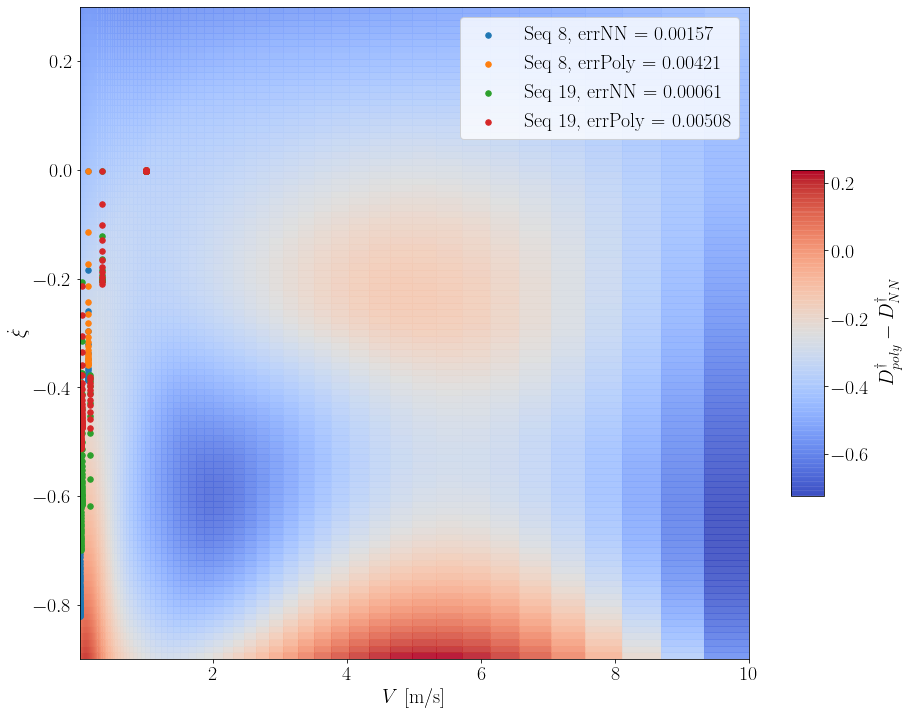

In [18]:
# Plot the surf first
# Initialize the plot
fig, ax = plt.subplots(figsize = (15, 12))# , subplot_kw={"projection": "3d"})
fsize=20

surf = ax.pcolormesh(Vin, Xi, D_dagger_poly_val - D_dagger_val, cmap=cm.coolwarm, clim=(-0.9, 0.9), 
                       linewidth=0, antialiased=False, alpha=0.9)

ax.set_xlim(np.min(Vin), np.max(Vin))
ax.set_ylim(np.min(Xi), np.max(Xi))
# ax.set_zlim(-0.9, 0.9)

if logVFlag:
    ax.set_xlabel("$\log_{10}(V)$ [m/s]", fontsize=fsize)
else:
    ax.set_xlabel("$V$ [m/s]", fontsize=fsize)
ax.set_ylabel("$\dot{\\xi}$",fontsize=fsize)
# ax.set_zlabel("$D_{poly}^\dagger-D_{NN}^\dagger$", fontsize=fsize)

# Add a color bar which maps values to colors.
cb = fig.colorbar(surf, shrink=0.5, aspect=10)
# cb.set_clim(-0.9, 0.9)
cb.set_label("$D_{poly}^\dagger-D_{NN}^\dagger$", fontsize=fsize)
cb.ax.tick_params(labelsize=fsize)
ax.tick_params(axis='both', which='major', labelsize=fsize)

# Sequences 
seqs = [8, 19]
NNLegends = ["8, errNN = 0.00157", "19, errNN = 0.00061"]
PolyLegends = ["8, errPoly = 0.00421", "19, errPoly = 0.00508"]

for idx, seq in enumerate(seqs):
    ax.scatter(Vs[seq, :].detach().numpy(), 
            xis[seq, :].detach().numpy(), 
            s=30, 
            marker="o", 
            alpha=1.0, 
            # c=colors[idx], 
            label="Seq " + NNLegends[idx])
    ax.scatter(Vs[seq, :].detach().numpy(), 
            xis_poly[seq, :].detach().numpy(), 
            s=30, 
            marker="o", 
            alpha=1.0, 
            # c=colors[idx], 
            label="Seq " + PolyLegends[idx])
ax.legend(fontsize=fsize)

plt.show()

# Plot $W(x)$

Text(0, 0.5, '$W(x)$')

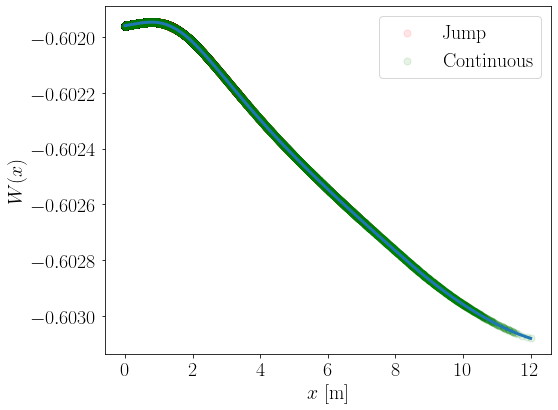

In [48]:
# Plot W(x)
W_val = myPotCal.W(torch.from_numpy(x).float().reshape([-1, 1])).reshape(-1).detach().numpy()
W_outss = []

fig, ax = plt.subplots(figsize = (8, 6.4))
ax.tick_params(axis='both', which='major', labelsize=fsize)

# Scatter all supporting datapoints
for idx in range(len(legends)):
    W_dataPts = myPotCal.W(torch.from_numpy(Xss[idx]).float().reshape([-1, 1])).reshape(-1).detach().numpy()
    ax.scatter(Xss[idx], W_dataPts, s=50, marker="o", alpha=0.1, c=colors[idx], label=legends[idx])
    W_outss.append(W_dataPts)
ax.legend(fontsize=fsize)

# Plot the curve
ax.plot(x, W_val, linewidth=3.0)

ax.set_xlabel("$x$ [m]", fontsize=fsize)
ax.set_ylabel("$W(x)$", fontsize=fsize)

Text(0, 0.5, '$W(x)$')

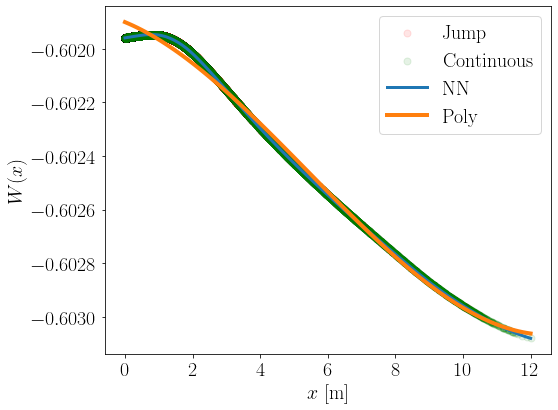

In [51]:
# Plot W(x)
W_val_poly = myPotCal_poly.W(torch.from_numpy(x).float().reshape([-1, 1])).reshape(-1).detach().numpy()
W_outss = []

fig, ax = plt.subplots(figsize = (8, 6.4))
ax.tick_params(axis='both', which='major', labelsize=fsize)

# # Scatter all supporting datapoints
for idx in range(len(legends)):
    W_dataPts = myPotCal.W(torch.from_numpy(Xss[idx]).float().reshape([-1, 1])).reshape(-1).detach().numpy()
    ax.scatter(Xss[idx], W_dataPts, s=50, marker="o", alpha=0.1, c=colors[idx], label=legends[idx])
    W_outss.append(W_dataPts)
# ax.legend(fontsize=fsize)

# Plot the curve
ax.plot(x, W_val, linewidth=3.0, label= "NN")
ax.plot(x, W_val_poly, linewidth=4.0, label="Poly")
ax.legend(fontsize=fsize)
ax.set_xlabel("$x$ [m]", fontsize=fsize)
ax.set_ylabel("$W(x)$", fontsize=fsize)

# 

# Plot $D^*(\dot{d})$

Text(0, 0.5, '$D^*(\\dot{d})$')

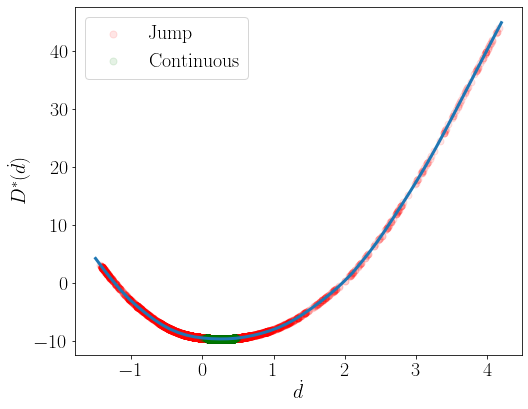

In [52]:
# Plot D^*(\dot{d})
Dstar_val = myPotCal.D(torch.from_numpy(Din).float().reshape([-1, 1])).reshape(-1).detach().numpy()

fig, ax = plt.subplots(figsize = (8, 6.4))
ax.tick_params(axis='both', which='major', labelsize=fsize)
Dstar_outss= []

# Scatter all supporting datapoints
for idx in range(len(legends)):
    Dstar_dataPts = myPotCal.D(torch.from_numpy(Dinss[idx]).float().reshape([-1, 1])).reshape(-1).detach().numpy()
    ax.scatter(Dinss[idx], Dstar_dataPts, s=50, marker="o", alpha=0.1, c=colors[idx], label=legends[idx])
    Dstar_outss.append(Dstar_dataPts)
ax.legend(fontsize=fsize)

# Plot the curve
ax.plot(Din, Dstar_val, linewidth=3.0)

ax.set_xlabel("$\dot{d}$", fontsize=fsize)
ax.set_ylabel("$D^*(\dot{d})$", fontsize=fsize)

Text(0, 0.5, '$D^*(\\dot{d})$')

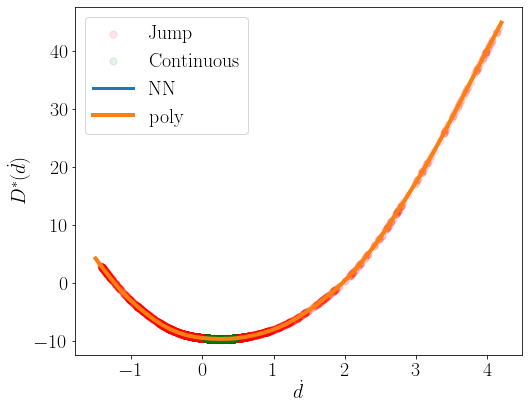

In [54]:
# Plot D^*(\dot{d})
Dstar_val = myPotCal.D(torch.from_numpy(Din).float().reshape([-1, 1])).reshape(-1).detach().numpy()
Dstar_val_poly = myPotCal.D(torch.from_numpy(Din).float().reshape([-1, 1])).reshape(-1).detach().numpy()

fig, ax = plt.subplots(figsize = (8, 6.4))
ax.tick_params(axis='both', which='major', labelsize=fsize)
Dstar_outss= []

# Scatter all supporting datapoints
for idx in range(len(legends)):
    Dstar_dataPts = myPotCal.D(torch.from_numpy(Dinss[idx]).float().reshape([-1, 1])).reshape(-1).detach().numpy()
    ax.scatter(Dinss[idx], Dstar_dataPts, s=50, marker="o", alpha=0.1, c=colors[idx], label=legends[idx])
    Dstar_outss.append(Dstar_dataPts)

# Plot the curve
ax.plot(Din, Dstar_val, linewidth=3.0, label ="NN")
ax.plot(Din, Dstar_val_poly, linewidth=4.0, label ="poly")
ax.legend(fontsize=fsize)

ax.set_xlabel("$\dot{d}$", fontsize=fsize)
ax.set_ylabel("$D^*(\dot{d})$", fontsize=fsize)

# Linear regression to find good approximation of $D^\dagger(\dot{x}, \xi), W(x), D^*(\dot{d})$

In [12]:
# Collect dataset first
DataFlag = "Grid" # "Combined", "Grid", "Traj"
if DataFlag == "Traj":
    xis = np.concatenate(xiss)
    Xs = np.concatenate(Xss)
    Vs = np.concatenate(Vss)
    Dins = np.concatenate(Dinss)
    # ts = np.concatenate(tss)
    # fs = np.concatenate(fss)
    # xiDots = np.concatenate(xiDotss)
    D_dagger_outs = np.concatenate(D_dagger_outss)
    Dstar_outs = np.concatenate(Dstar_outss)
    W_outs = np.concatenate(W_outss)

elif DataFlag == "Grid":
    Xs = x
    W_outs = W_val
    Vs = DotX.reshape([-1]) 
    xis = Xi.reshape([-1])
    # xiDots = 
    # fs = 
    D_dagger_outs = D_dagger_val.reshape([-1])
    Dstar_outs = Dstar_val
    Dins = Din
elif DataFlag == "Combined":
    pass

# If drop duplicate
drop_duplicate = True
if drop_duplicate and (DataFlag == "Traj" or DataFlag == "Combined"):
    dup_arg = np.concatenate([Xs.reshape([-1, 1]), Vs.reshape([-1, 1]), xis.reshape([-1, dim_xi])], axis=1)
    unqs, indices = np.unique(dup_arg, axis = 0, return_index = True)
    print("Sampled, total counts of data points: {0}, {1}".format(len(indices), len(Xs)))
    xis = xis[indices]
    Xs = Xs[indices]
    Vs = Vs[indices]
    Dins = Dins[indices]
    # ts = ts[indices]
    # fs = fs[indices]
    # xiDots = xiDots[indices]
    D_dagger_outs = D_dagger_outs[indices]
    Dstar_outs = Dstar_outs[indices]
    W_outs = W_outs[indices]

# For D^\dagger
def D_dagger_poly_input(Vs, xis):
    # res = np.stack([Vs, 
    #                 Vs ** 2, 
    #                 xis, 
    #                 xis ** 2, 
    #                 Vs * xis, 
    #                 np.log(Vs), 
    #                 np.log(Vs) * xis]).transpose()

    res = np.stack([np.abs(Vs), 
                    np.abs(Vs) ** 2, 
                    xis, 
                    xis ** 2, 
                    np.log(np.abs(Vs)), 
                    # torch.log(Vs) ** 2, 
                    np.abs(Vs) * xis, 
                    np.log(np.abs(Vs)) * np.abs(Vs), 
                    np.log(np.abs(Vs)) * xis, 
                    np.log(np.abs(Vs)) * (Vs ** 2), 
                    np.abs(Vs) * np.log(np.abs(Vs)) * xis, 
                    # (torch.log(Vs) ** 2) * Vs, 
                    np.log(np.abs(Vs)) * (xis ** 2),  
                    # (torch.log(Vs) ** 2) * xis, 
                    ],).transpose()
    return res

# For W
def W_poly_input(Xs):
    res = np.stack([np.abs(Xs), np.abs(Xs) ** 2, np.abs(Xs) ** 3]).transpose()
    return res

# For Dstar
def Dstar_poly_input(Dins):
    res = np.stack([Dins, Dins ** 2, Dins ** 3, Dins ** 4]).transpose()
    return res

In [13]:
from sklearn import linear_model
X_D_dagger = D_dagger_poly_input(Vs, xis)
print(X_D_dagger.shape)
X_W = W_poly_input(Xs)
X_Dstar = Dstar_poly_input(Dins)

# For D_dagger
D_dagger_regress = linear_model.LinearRegression()
D_dagger_regress.fit(X_D_dagger, D_dagger_outs)
D_dagger_score = D_dagger_regress.score(X_D_dagger, D_dagger_outs)
print("D_dagger R^2: ", D_dagger_score)

# For W
W_regress = linear_model.LinearRegression()
W_regress.fit(X_W, W_outs)
W_score = W_regress.score(X_W, W_outs)
print("W R^2: ", W_score)

# For Dstar
Dstar_regress = linear_model.LinearRegression()
Dstar_regress.fit(X_Dstar, Dstar_outs)
Dstar_score = Dstar_regress.score(X_Dstar, Dstar_outs)
print("Dstar R^2: ", Dstar_score)

(10000, 11)
D_dagger R^2:  0.9940563410288382
W R^2:  0.9976682109030658
Dstar R^2:  0.999591417757002


In [14]:
D_dagger_regress.coef_

array([ 1.14170321, -0.16300173,  0.95911095,  1.50812843, -0.12611818,
       -1.39934015, -0.19156679, -0.01132747,  0.0513429 ,  0.54516219,
        0.16668256])

In [15]:
# Make functions of W, D_dagger, Dstar for pytorch
from FrictionNNModels import Dstar_poly, W_poly, D_dagger_poly
# class D_dagger_poly(nn.Module):
#     def __init__(self, intercept = torch.tensor(0.), coef = torch.zeros(13)):
#         super().__init__()
#         self.intercept = nn.Parameter(intercept)
#         self.coef = nn.Parameter(coef.reshape([-1, 1]))
    
#     def forward(self, x):
#         Vs = x[:, :1]
#         xis = x[:, 1:]
#         Xin = torch.concat([Vs, 
#                     Vs ** 2, 
#                     xis, 
#                     xis ** 2, 
#                     torch.log(Vs), 
#                     torch.log(Vs) ** 2, 
#                     Vs * xis, 
#                     torch.log(Vs) * Vs, 
#                     torch.log(Vs) * xis, 
#                     torch.log(Vs) * (Vs ** 2), 
#                     (torch.log(Vs) ** 2) * Vs, 
#                     torch.log(Vs) * (xis ** 2), 
#                     (torch.log(Vs) ** 2) * xis], dim = 1)
#         # print("Xin.shape: ", Xin.shape)
#         # print("self.coef: ", self.coef.shape)
#         # print("self.intercept: ", self.intercept.shape)

#         res = torch.matmul(Xin, self.coef) + self.intercept
#         return res

WPoly = W_poly(torch.tensor(W_regress.intercept_), torch.from_numpy(W_regress.coef_))
D_daggerPoly = D_dagger_poly(torch.tensor(D_dagger_regress.intercept_), torch.from_numpy(D_dagger_regress.coef_))
DstarPoly = Dstar_poly(torch.tensor(Dstar_regress.intercept_), torch.from_numpy(Dstar_regress.coef_))

In [16]:
# Calculate the error
from FrictionNNModels import PotentialsGivenPolyCorrection
kwgsGivenPoly = {
    "dim_xi": dim_xi, 
    "W" : WPoly, 
    "D_dagger" : D_daggerPoly, 
    "D" : DstarPoly, 
    "device" : torch.device("cpu"), 
    "learning_rate" : 0.001, 
    "learning_rate_D" : 0.001, 
    "learning_rate_D_dagger" : 0.001, 
}

myPoly = PotentialsGivenPolyCorrection(kwgsGivenPoly)
# myPoly.save("./model/Trial0216_smallDRS_smallA_400_GivenPoly_noLog2_dimXi_1_dict")
myPoly.save("./model/Trial0216_combined_800_GivenPoly_grid_LogCross_dimXi_1_dict")

# Linear regression on $\xi$ from 2 trained models

In [2]:
# First load the dataset
dataPrefix = "Trial0216_combined_800"
shit = torch.load("./data/{0}.pt".format(dataPrefix))
Vs = shit["Vs"]
thetas = shit["thetas"]
fs = shit["fs"]
ts = shit["ts"]

# Calculate Xs
Xs = torch.zeros(Vs.shape)
Xs[:, 1:] = torch.cumulative_trapezoid(Vs, ts)

In [3]:
# Model prefixs
modelPrefixs = ["Trial0216_combined_800", "Trial0112_combined", "Trial0216_smallDRS_smallA_400"]
plotTitles = ["Trial0216_combined_800", "Trial0112_combined_400", "Trial0216_smallDRS_smallA_400"]
dict_flags = [True, False, False]
dim_xi = 1

# Store the trained models and Pots
myModels = []
myPotCals = []
myXis = []
myXiDots = []
myDins = []

# Loop all modelPrefixs
for i, modelPrefix in enumerate(modelPrefixs):
    print(modelPrefix)
    myModel = load_model(modelPrefix, torch.device("cpu"), dim_xi, dict_flags[i])

    # Calculate xis, xiDots trajectories
    myPotCal = PotsCalXiXiDot(myModel)
    myPotCal.calf(Xs, Vs, ts)
    xis = myPotCal.xis
    xiDots = myPotCal.xiDots
    Dins = myPotCal.Dins

    # Store models and data
    myModels.append(myModel)
    myPotCals.append(myPotCal)
    myXis.append(xis)
    myXiDots.append(xiDots)
    myDins.append(Dins)

Trial0216_combined_800
Trial0112_combined
Trial0216_smallDRS_smallA_400


----------------------------------------
Regressing xi from Trial0112_combined on Trial0216_combined_800:
slope, intercept:  0.7774695956383375      0.02196987223634092
R^2: 0.9861695202177663
----------------------------------------
Regressing xi from Trial0216_smallDRS_smallA_400 on Trial0216_combined_800:
slope, intercept:  -0.9695566412024225      -0.01303213570439668
R^2: 0.9950523198370698


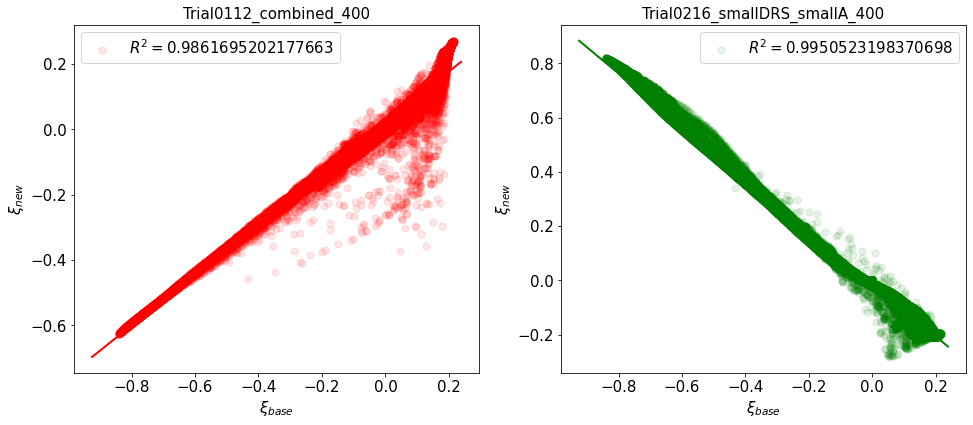

In [4]:
# Perform linear regression
from scipy.stats import linregress
Base_Xis = myXis[0].reshape(-1).detach().numpy()
plot_xs = np.linspace(1.1 * min(Base_Xis), 1.1 * max(Base_Xis), 100)
colors = ["red", "green"]
legends = "$R^2 = $"

# Set the plot
fsize = 15
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6.4))


# Plot the asses
for idx in range(1, len(myXis)):
    axs[idx - 1].tick_params(axis='both', which='major', labelsize=fsize)
    this_Xis = myXis[idx].reshape(-1).detach().numpy()
    res = linregress(Base_Xis, this_Xis)
    print("-" * 40)
    print("Regressing xi from {0} on {1}:".format(modelPrefixs[idx], modelPrefixs[0]))
    print("slope, intercept: ", res.slope, "    ", res.intercept)
    print("R^2:", res.rvalue ** 2)
    plot_ys = res.slope * plot_xs + res.intercept
    axs[idx - 1].scatter(Base_Xis, this_Xis, s=50, marker="o", alpha=0.1, c=colors[idx - 1], label=legends + str(res.rvalue ** 2))
    axs[idx - 1].plot(plot_xs, plot_ys, linewidth=2.0, color=colors[idx - 1] )
    axs[idx - 1].legend(fontsize = fsize)
    axs[idx - 1].set_xlabel("$\\xi_{base}$", fontsize=fsize)
    axs[idx - 1].set_ylabel("$\\xi_{new}$", fontsize=fsize)
    axs[idx - 1].set_title(plotTitles[idx], fontsize=fsize)



# Plot the distribution of $\xi$ of different datasets on the same model

In [10]:
# Specify the datasets we want to examine
dataPrefixs = ["Trial0112_combined", "Trial0112_smallDRS_smallA", "Trial0112_smallDRS_Burigede", "Trial0216_smallDRS_smallA_400"]
plotTitles = ["Combined_400", "VJump_200", "Continuous_200", "VJump_400"]
myXis = []
myDins = []

# Get the potential for baseline model
myPotCal = myPotCals[0]

# Loop through dataPrefixs
for idx, dataPrefix in enumerate(dataPrefixs):
    shit = torch.load("./data/{0}.pt".format(dataPrefix))
    Vs = shit["Vs"]
    thetas = shit["thetas"]
    fs = shit["fs"]
    ts = shit["ts"]

    # Calculate Xs
    Xs = torch.zeros(Vs.shape)
    Xs[:, 1:] = torch.cumulative_trapezoid(Vs, ts)

    # Calculate xis
    myPotCal.calf(Xs, Vs, ts)
    myXis.append(myPotCal.xis.reshape(-1).detach().numpy())
    myDins.append(myPotCal.Dins.reshape(-1).detach().numpy())

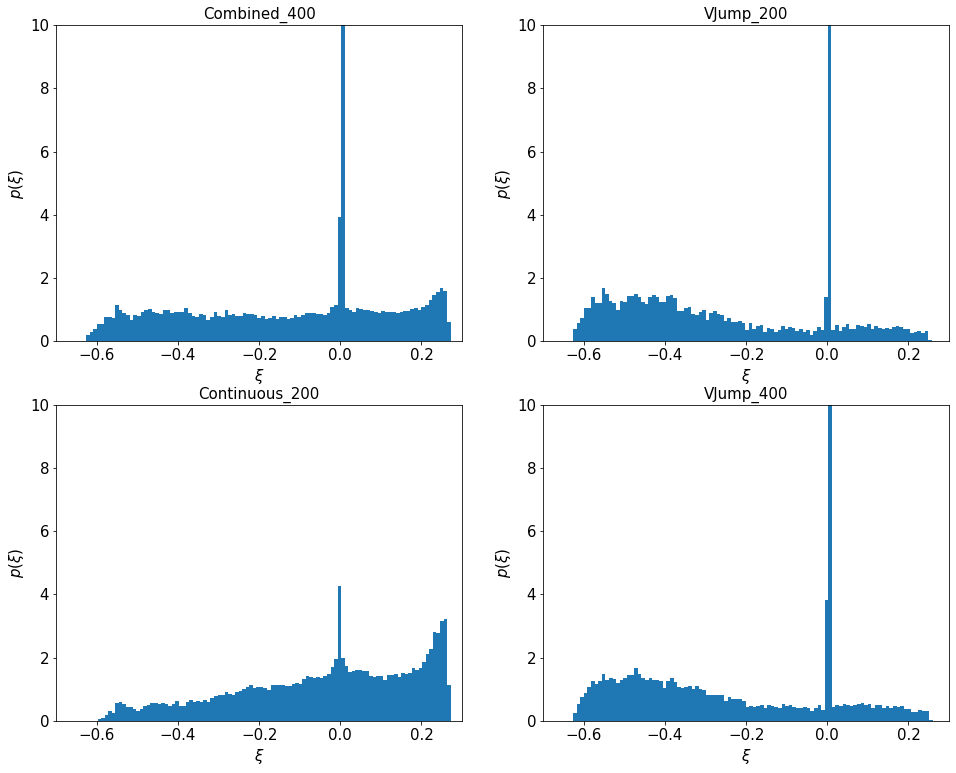

In [11]:
# Plot distribution of \xi
# Set up histograms
fsize = 15
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 12.8))
nBins = 100

# Loop through dataPrefixs
for idx, dataPrefix in enumerate(dataPrefixs):
    axs[idx // 2][idx % 2].tick_params(axis='both', which='major', labelsize=fsize)
    axs[idx // 2][idx % 2].hist(myXis[idx], bins=nBins, density=True)
    axs[idx // 2][idx % 2].set_xlabel("$\\xi$", fontsize=fsize)
    axs[idx // 2][idx % 2].set_ylabel("$p(\\xi)$", fontsize=fsize)
    axs[idx // 2][idx % 2].set_xlim(-0.7, 0.3)
    axs[idx // 2][idx % 2].set_ylim(0., 10.)
    axs[idx // 2][idx % 2].set_title(plotTitles[idx], fontsize=fsize)

# Plot the distribution of $-\frac{\partial D^\dagger}{\partial \xi}$ of different datasets on the same model

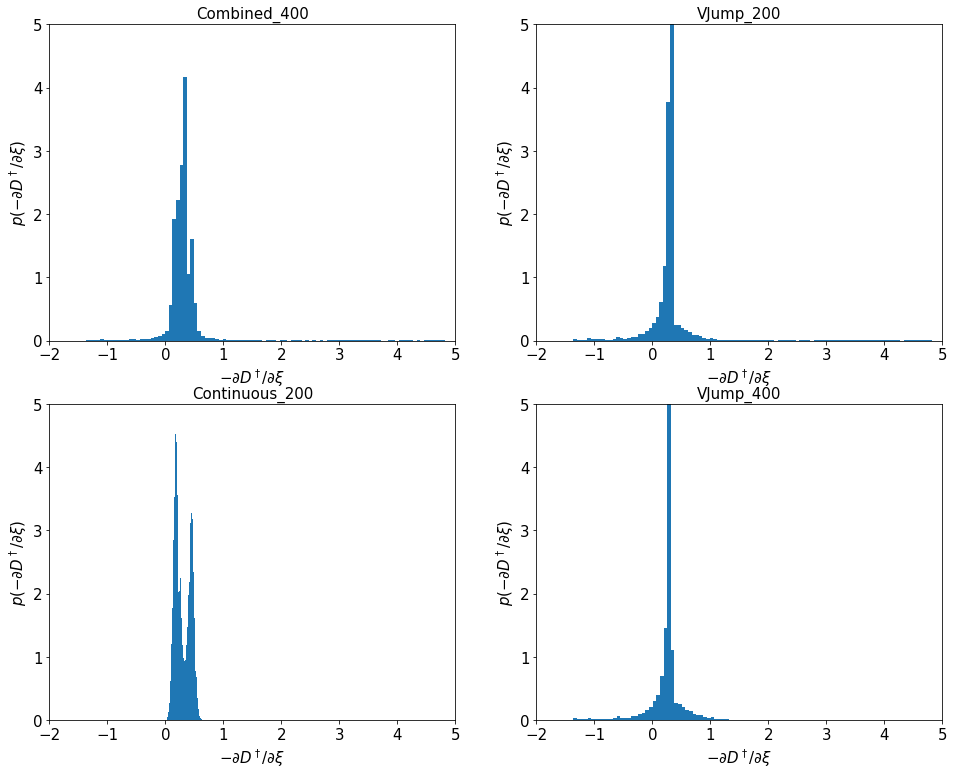

In [16]:
# Plot distribution of \xi
# Set up histograms
fsize = 15
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 12.8))
nBins = 100

# Loop through dataPrefixs
for idx, dataPrefix in enumerate(dataPrefixs):
    axs[idx // 2][idx % 2].tick_params(axis='both', which='major', labelsize=fsize)
    axs[idx // 2][idx % 2].hist(myDins[idx], bins=nBins, density=True)
    axs[idx // 2][idx % 2].set_xlabel("$-\partial D^\dagger / \partial \\xi$", fontsize=fsize)
    axs[idx // 2][idx % 2].set_ylabel("$p(-\partial D^\dagger / \partial \\xi)$", fontsize=fsize)
    axs[idx // 2][idx % 2].set_xlim(-2, 5)
    axs[idx // 2][idx % 2].set_ylim(0., 5.)
    axs[idx // 2][idx % 2].set_title(plotTitles[idx], fontsize=fsize)